In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import os

from weight import array_weight_vector
from utils import find_position_vector, find_steering_matrix, Time, corelation, nsb

repo_dir = os.getcwd()
tm = Time()

## Sample Location Generation For Testing

In [2]:
%matplotlib notebook
np.random.seed(6)

P,Q = 8,8 # rows and columns of antenna array
lamda = 1 # wavelength
ue = 1  # number of user equipments
ris = 1  # number of RIS
n_source = ue+ris
n_antenna = P*Q  # number of antenna elements 
snr = 10

print('\nsimulation sample data\n----------------------')
array = np.linspace(0,(n_antenna-1)/2,n_antenna)

# angle for RIS would be added
p_thetas = (np.pi/3)*(np.random.rand(n_source))   # random source polar directions
az_thetas = (2*np.pi)*(np.random.rand(n_source))   # random source azimuthal directions

# power from RIS would be added
ue_alphas = np.sqrt(1/2)*(np.random.randn(ue) + np.random.randn(ue)*1j) # random UE powers
ris_alphas = np.sqrt(1/2)*(np.random.randn(ris) + np.random.randn(ris)*1j) # random RIS powers

print('random signal direction #polar:',p_thetas*180/np.pi)
print('random signal direction #azimuthal:',az_thetas*180/np.pi)

ue_vectors, ris_vectors = [],[]
ue_angles, ris_angles = [], []
for polar,az in zip(p_thetas[:ue],az_thetas[:ue]):
    ue_vectors.append(find_position_vector(polar,az))
    ue_angles.append([polar*180/np.pi,az*180/np.pi])

for polar,az in zip(p_thetas[ue:],az_thetas[ue:]):
    ris_vectors.append(find_position_vector(polar,az))
    ris_angles.append([polar*180/np.pi,az*180/np.pi])

bs_vector = [0,0,0]
print('\nbase station locations:',bs_vector)
print(f'\nRIS \ndirection vectors: {ris_vectors}\ndirection angles: {ris_angles}\npower: {ris_alphas}')
print(f'\nuser equipment \ndirection vectors: {ue_vectors}\ndirection angles: {ue_angles}\npower: {ue_alphas}')


simulation sample data
----------------------
random signal direction #polar: [53.57160909 19.91878832]
random signal direction #azimuthal: [295.6424843   15.01078526]

base station locations: [0, 0, 0]

RIS 
direction vectors: [[0.006067509241204118, 2.7744162567926823e-05, 0.9999815921115096]]
direction angles: [[19.918788318070632, 15.010785261089966]]
power: [-1.75841946+0.64576634j]

user equipment 
direction vectors: [[0.016251992379168842, 0.0014675892375824373, 0.9998668505983872]]
direction angles: [[53.571609086160095, 295.64248430081943]]
power: [0.15402256-0.63575391j]


## Sample Data Generation

In [3]:
numAngles = 360
p_angles = np.linspace(0,np.pi/3,numAngles)*180/np.pi
az_angles = np.linspace(0,2*np.pi,numAngles)*180/np.pi
general_angles = np.array(np.meshgrid(p_angles,az_angles)).T.reshape(-1, 2).tolist()
print('Total sample location collected:', len(general_angles))

Total sample location collected: 129600


# Deep Learning

In [58]:
tm.start(message='weight by deep learning')
antenna_weight = array_weight_vector(ris_vectors,ue_vectors,ris_angles,ue_angles,vector=True,angle=True)
tm.end()
recived_power = [power*antenna_weight for power in ris_alphas][0]+[power*antenna_weight for power in ue_alphas][0]


>> weight by deep learning: Done!! Time taken: 0.0063 sec


In [5]:
antenna_weight.shape

(64,)

In [6]:
# general_corr = []

# tm.start(message="coorelation using deep learning")
# for i,angle in enumerate(general_angles):
#     specified_vector = find_position_vector(angle[0],angle[1])
#     general_weights = array_weight_vector(ris_vectors=ris_vectors,
#                                           ue_vectors=[specified_vector],
#                                           ris_angles=ris_angles,
#                                           ue_angles=[angle],
#                                           vector=True,
#                                           angle=True)
#     general_corr.append(corelation(recived_power,general_weights))
# tm.end()

In [79]:
file_path = os.path.join(repo_dir,'data','weight_correlation.pkl')
# with open(file_path, 'wb') as file:
#     pkl.dump(general_corr, file)
    
with open(file_path, 'rb') as file:
    general_corr = pkl.load(file)

<IPython.core.display.Javascript object>


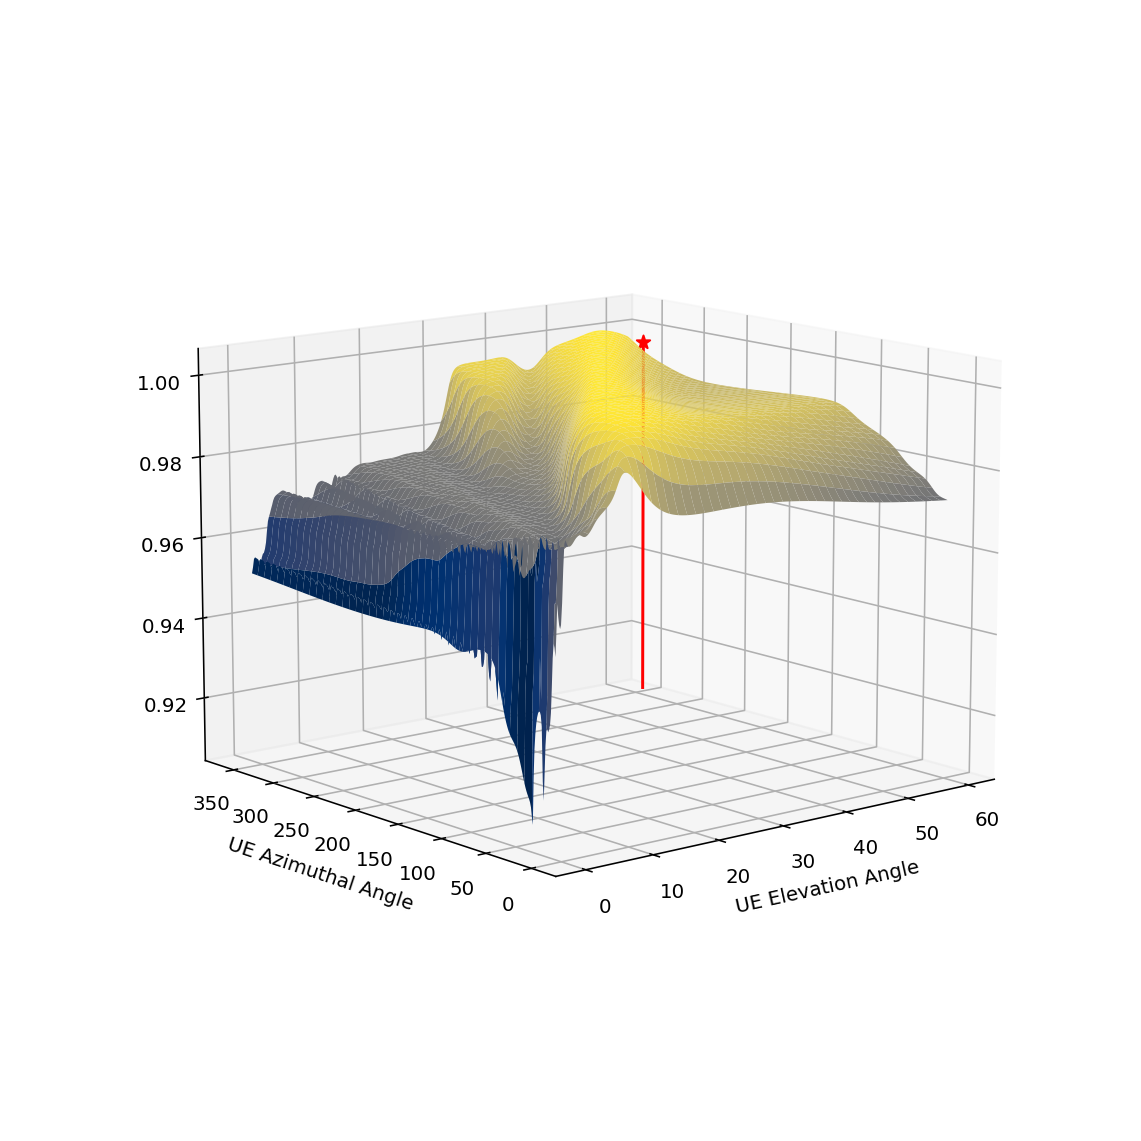

Coorelation Plot for Deep Learning Method


In [83]:
%matplotlib notebook
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(p_angles, az_angles)
Z = np.array(general_corr).reshape(len(az_angles), len(p_angles))
# print(X.shape, Y.shape, Z.shape)

ax.scatter(ue_angles[0][0], ue_angles[0][1],corelation(recived_power,antenna_weight),color='r',marker='*',s=50)
ax.plot([ue_angles[0][0],ue_angles[0][0]],
        [ue_angles[0][1],ue_angles[0][1]],
        [min(general_corr),corelation(recived_power,antenna_weight)],
        color='r'
       )
surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=5)
ax.set_ylabel('UE Azimuthal Angle', labelpad=5)
# ax.set_title("Coorelation Plot")
print("Coorelation Plot for Deep Learning Method")
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

# NSB Algorithm

In [59]:
pos_angles = ris_angles+ue_angles

tm.start(message='weight by NSB algorithm')
nsb_antenna_weight = nsb(P,Q, wavelength=lamda, pos_angles=pos_angles).reshape(-1,)
tm.end()
nsb_recived_power = [power*nsb_antenna_weight for power in ris_alphas][0]+[power*nsb_antenna_weight for power in ue_alphas][0]


>> weight by NSB algorithm: Done!! Time taken: 0.1109 sec


In [10]:
nsb_antenna_weight.shape

(64,)

In [42]:
general_corr = []

tm.start(message="coorelation using NSB algorithm")
for i,angle in enumerate(general_angles):
    general_weights = nsb(P,Q, wavelength=lamda, pos_angles=ris_angles+[angle]).reshape(-1,)
    general_recived_power = [power*general_weights for power in ris_alphas][0]+[power*general_weights for power in ue_alphas][0]
    general_corr.append(corelation(nsb_recived_power,general_recived_power))
tm.end()


>> coorelation using NSB algorithm: Done!! Time taken: 58.6095 sec


In [87]:
file_path = os.path.join(repo_dir,'data','weight_correlation_nsb.pkl')
# with open(file_path, 'wb') as file:
#     pkl.dump(general_corr, file)
    
with open(file_path, 'rb') as file:
    general_corr = pkl.load(file)

<IPython.core.display.Javascript object>


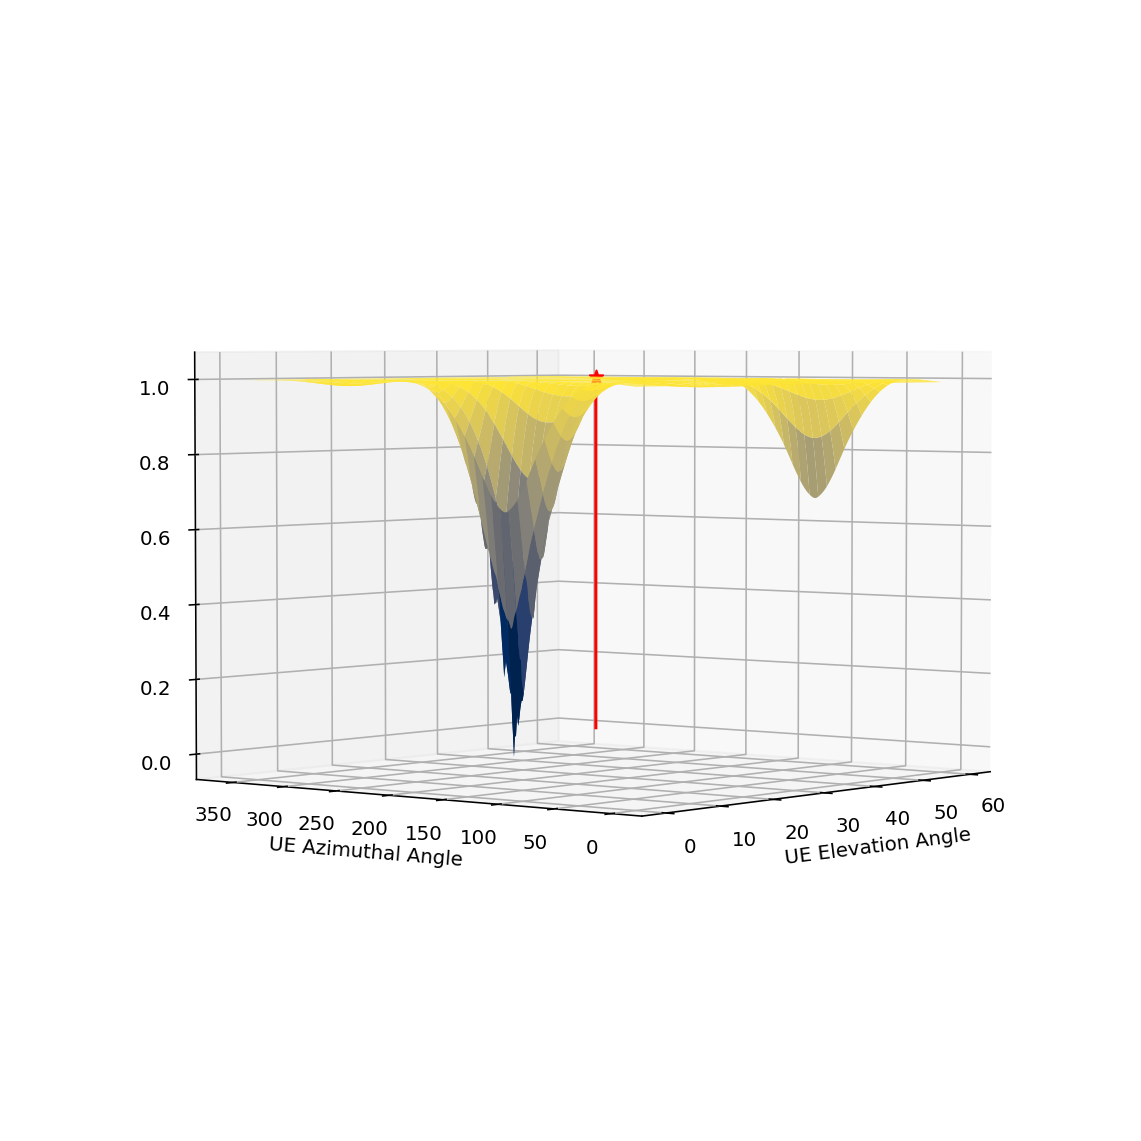

Coorelation Plot for NSB method


In [89]:
%matplotlib notebook
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(p_angles, az_angles)
Z = np.array(general_corr).reshape(len(az_angles), len(p_angles))
# print(X.shape, Y.shape, Z.shape)

ax.scatter(ue_angles[0][0], ue_angles[0][1],corelation(nsb_recived_power,nsb_antenna_weight),color='r',marker='*',s=50)
ax.plot([ue_angles[0][0],ue_angles[0][0]],
        [ue_angles[0][1],ue_angles[0][1]],
        [min(general_corr),corelation(nsb_recived_power,nsb_antenna_weight)],
        color='r'
       )
surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=5)
ax.set_ylabel('UE Azimuthal Angle', labelpad=5)
# ax.set_title("Coorelation Plot")
print("Coorelation Plot for NSB method")
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

# Capon Algorithm

In [35]:
M = P*Q # number of antenna elements (sensors)

Rss = np.eye((2))# correlation matrix of the information symbols
Rnn = 0.1*np.eye((M))# correlation matrix of additive noise
A = find_steering_matrix(wavelength=lamda, pos_angles=pos_angles, planar_antenna_shape=(P,Q)) # steering vectors
R = A @ Rss @ np.conj(A).T + Rnn # correlation matrix
g = np.array([1,1]) # gate array: both DoAs are "switched on"

In [60]:
tm.start(message='weight by Capon algorithm')
capon_antenna_weight = capon(A,R,g)
tm.end()
capon_recived_power = [power*capon_antenna_weight for power in ris_alphas][0]+[power*capon_antenna_weight for power in ue_alphas][0]


>> weight by Capon algorithm: Done!! Time taken: 0.0882 sec


In [94]:
ris_angles+[angle]

[[19.918788318070632, 15.010785261089966], [59.99999999999999, 360.0]]

In [90]:
general_corr = []

tm.start(message="coorelation using Capon algorithm")
for i,angle in enumerate(general_angles):
    A = find_steering_matrix(wavelength=lamda, pos_angles=ris_angles+[angle], planar_antenna_shape=(P,Q))
    R = A @ Rss @ np.conj(A).T + Rnn
    g = np.array([1,1])

    general_weights = capon(A,R,g)
    general_recived_power = [power*general_weights for power in ris_alphas][0]+[power*general_weights for power in ue_alphas][0]
    general_corr.append(corelation(capon_recived_power,general_recived_power))
tm.end()


>> coorelation using Capon algorithm: Done!! Time taken: 127.9011 sec


<IPython.core.display.Javascript object>


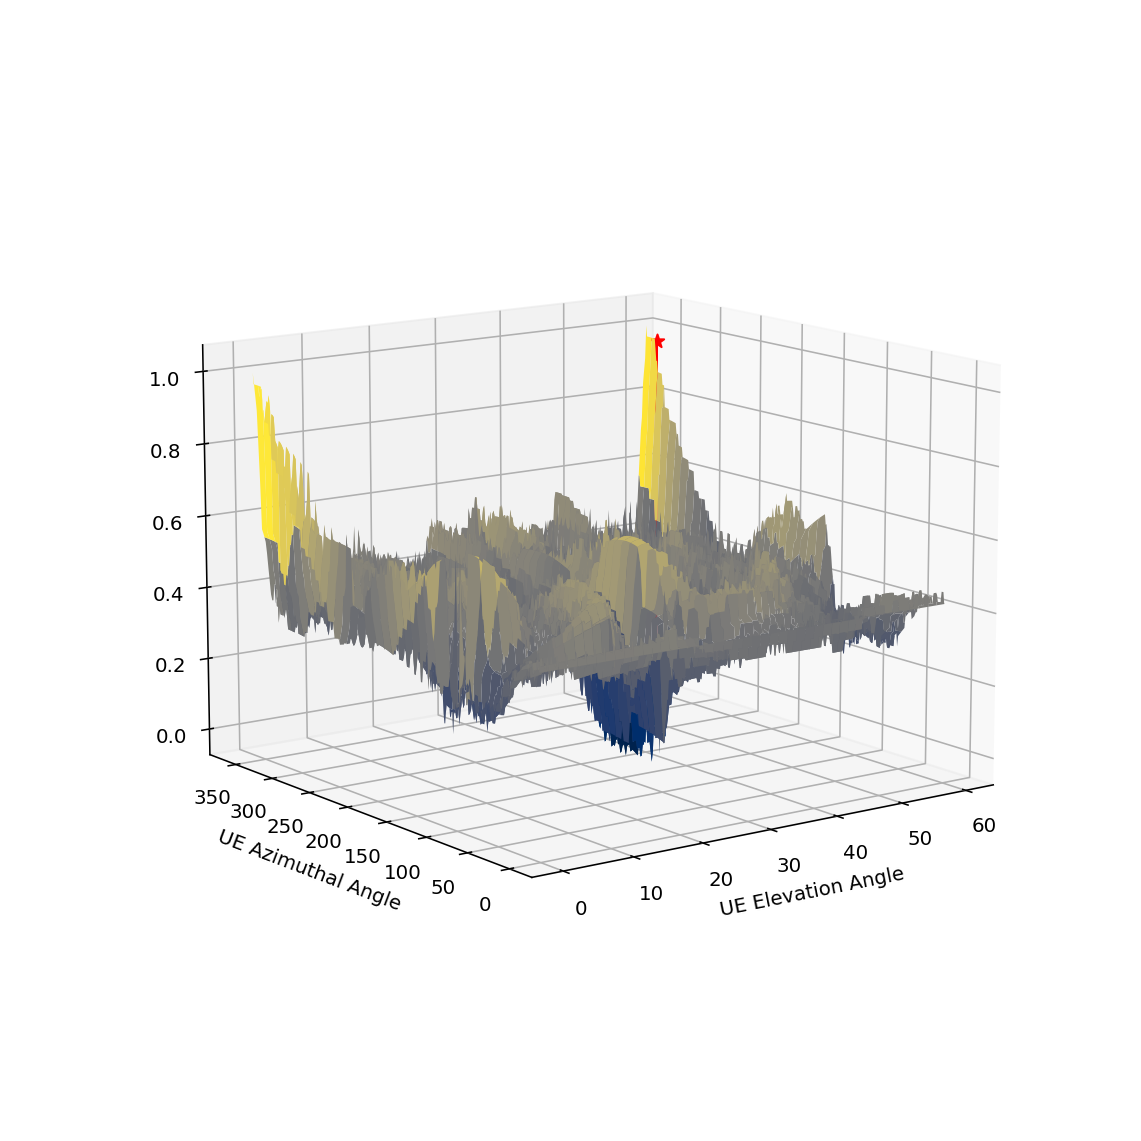

Coorelation Plot for Capon Method


In [93]:
%matplotlib notebook
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(p_angles, az_angles)
Z = np.array(general_corr).reshape(len(az_angles), len(p_angles))

ax.scatter(ue_angles[0][0], 
           ue_angles[0][1],
           corelation(capon_recived_power,capon_antenna_weight),
           color='r',
           marker='*',
           s=50)
ax.plot([ue_angles[0][0],ue_angles[0][0]],
        [ue_angles[0][1],ue_angles[0][1]],
        [0,corelation(capon_recived_power,capon_antenna_weight)],
        color='r'
       )
surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

ax.set_xlabel('UE Elevation Angle', labelpad=5)
ax.set_ylabel('UE Azimuthal Angle', labelpad=5)
print("Coorelation Plot for Capon Method")
plt.show()

# Bartlett's method

In [72]:
M = P*Q # number of antenna elements (sensors)

A = find_steering_matrix(wavelength=lamda, pos_angles=pos_angles, planar_antenna_shape=(P,Q)) # steering vectors
tm.start(message='weight by Bartlett algorithm')
bartlett_antenna_weight = np.average(A,axis=1)/M
tm.end()

bartlett_recived_power = [power*bartlett_antenna_weight for power in ris_alphas][0] \
                        +[power*bartlett_antenna_weight for power in ue_alphas][0]


>> weight by Bartlett algorithm: Done!! Time taken: 0.0002 sec


In [84]:
general_corr = []

tm.start(message="coorelation using Bartlett algorithm")
for i,angle in enumerate(general_angles):
    A = find_steering_matrix(wavelength=lamda, pos_angles=ris_angles+[angle], planar_antenna_shape=(P,Q))
    general_weights = np.average(A,axis=1)/M
    general_recived_power = [power*general_weights for power in ris_alphas][0]+[power*general_weights for power in ue_alphas][0]
    general_corr.append(corelation(bartlett_recived_power,general_recived_power))
tm.end()


>> coorelation using Bartlett algorithm: Done!! Time taken: 60.8031 sec


<IPython.core.display.Javascript object>


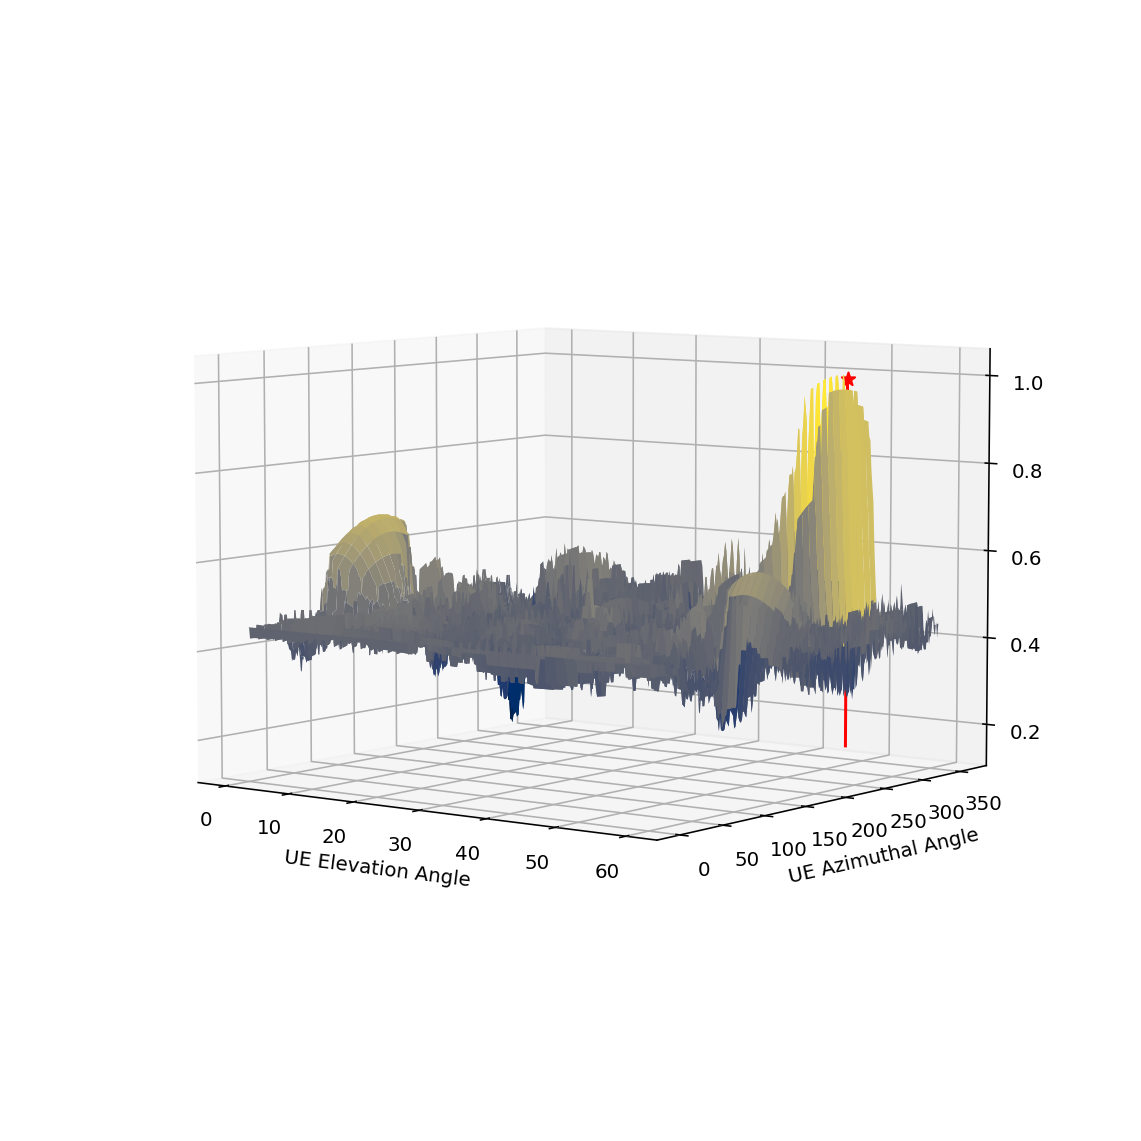

Coorelation Plot for Bartlett Method


In [86]:
%matplotlib notebook
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(p_angles, az_angles)
Z = np.array(general_corr).reshape(len(az_angles), len(p_angles))

ax.scatter(ue_angles[0][0], 
           ue_angles[0][1],
           corelation(bartlett_recived_power,bartlett_antenna_weight),
           color='r',
           marker='*',
           s=50)
ax.plot([ue_angles[0][0],ue_angles[0][0]],
        [ue_angles[0][1],ue_angles[0][1]],
        [min(general_corr), corelation(bartlett_recived_power,bartlett_antenna_weight)],
        color='r')
surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

ax.set_xlabel('UE Elevation Angle', labelpad=5)
ax.set_ylabel('UE Azimuthal Angle', labelpad=5)
print("Coorelation Plot for Bartlett Method")
plt.show()